# load data

download dataset from kaggle [https://www.kaggle.com/xainano/handwrittenmathsymbols](https://www.kaggle.com/xainano/handwrittenmathsymbols) (a large `rar` file within `zip` file), and extract the images. The folder structure should be similar as below

```bash
Team-3-Quantum-Hackers-Project/
├── README.md
├── LICENSE
├── .gitignore
├── load_data.ipynb
└── extracted_images/
    ├── 0/
    |   ├── 0_100070.jpg
    |   ├── 0_100080.jpg
    |   ├── 0_100081.jpg
    |   └── ...
    ├── 1/
    ├── !/
    ├── (/
    ├── )/
    └── ...
```

In [1]:
import os
import time
import glob
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import skimage
import sklearn.model_selection
import sklearn.svm

In [2]:
datadir = 'extracted_images'
all_label = os.listdir(datadir)
all_image_path = {x:[os.path.join(datadir,x,y) for y in os.listdir(os.path.join(datadir,x))] for x in all_label}
    
print('all label:', all_label)
print('some image path:')
for x in list(all_image_path.keys())[:4]:
    print(x, all_image_path[x][:2])

all label: ['beta', 'infty', 'cos', '6', '0', 'prime', '=', 'gt', 'o', 'lt', 'y', 'b', '!', 'T', 'C', 'leq', 'R', 'exists', 'p', 'N', '3', '{', 'H', 'z', 'ascii_124', 'alpha', 'sigma', '9', 'int', 'q', 'l', 'lambda', 'A', 'theta', '2', 'S', '5', 'sqrt', '7', 'sum', '4', 'v', 'e', 'M', 'forall', 'j', '-', ')', '1', 'w', '(', 'phi', 'i', ',', 'lim', 'Delta', 'G', '8', 'u', 'k', 'rightarrow', 'div', 'neq', '[', 'pi', ']', 'f', 'geq', 'pm', 'forward_slash', 'gamma', '}', 'X', '+', 'times', 'log', 'tan', 'd', 'in', 'sin', 'ldots', 'mu']
some image path:
beta ['extracted_images/beta/beta_57145.jpg', 'extracted_images/beta/exp26500.jpg']
infty ['extracted_images/infty/exp96368.jpg', 'extracted_images/infty/exp78043.jpg']
cos ['extracted_images/cos/exp48148.jpg', 'extracted_images/cos/exp91430.jpg']
6 ['extracted_images/6/exp22030.jpg', 'extracted_images/6/6_56393.jpg']


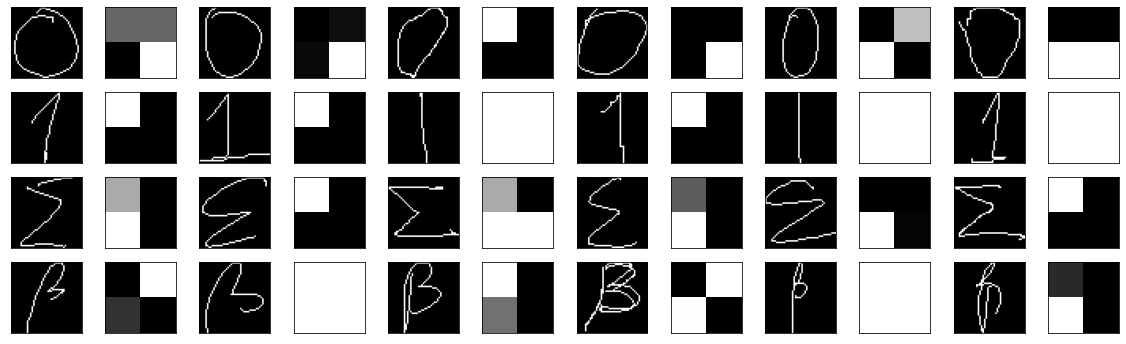

In [3]:
plot_label_list = ['0', '1', 'sum', 'beta']
num_column = 6
resize_image_size = 2,2
# resize_image_size = 4, 1
fig, ax_list = plt.subplots(nrows=len(plot_label_list), ncols=2*num_column, figsize=(20, 6))
for i in range(len(plot_label_list)):
    image_list = all_image_path[plot_label_list[i]]
    random_index = np.random.choice(np.arange(len(image_list)), size=num_column)
    for j in range(num_column):
        path = image_list[random_index[j]]
        image = np.array(PIL.Image.open(path))
        # image_small = np.array(PIL.Image.open(path).resize((resize_image_size[1],resize_image_size[0]))) #resize(width,height)
        image_small = skimage.transform.resize(image, resize_image_size, anti_aliasing=False)
        ax_list[i,2*j].imshow(image, cmap=plt.cm.gray_r)
        ax_list[i,2*j].set_xticks([])
        ax_list[i,2*j].set_yticks([])
        ax_list[i,2*j+1].imshow(image_small, cmap=plt.cm.gray_r)
        ax_list[i,2*j+1].set_xticks([])
        ax_list[i,2*j+1].set_yticks([])

In [4]:
import numpy as np
# Getting pixel value of 2x2 matrix
im = PIL.Image.open(path, 'r')
# im_small = skimage.transform.resize(image, resize_image_size, anti_aliasing=False)
im_small = im.resize((resize_image_size[1],resize_image_size[0]))
# print(type(im_small))
# print(im_small)
# print(im_small.getdata())
pix_val = list(im_small.getdata())

print(pix_val)
print(len(pix_val))
# display(im_small)

[232, 237, 234, 242]
4


**TODO**: how to combine it with Quantum Machine Learning

quantum SVM? CircuitQNN?

## preprocess data

1. select label
2. select part of the data, otherwise itt takes too long to train on the whole dataset
3. split train and test set

In [5]:
# binary classification
labels = ['0', '1']
label_to_int = {labels[0]:0, labels[1]:1}
class_size = 100
resize_image_size = 2,2
# resize_image_size = 4, 1
seed = None #to fix the result, change it to seed=23 or some other integer

data_list = []
label_list = []
for x in labels:
    image_list = all_image_path[x]
    random_index = np.random.choice(np.arange(len(image_list)), size=class_size)
    for i in random_index:
        path = image_list[i]
        data_list.append(np.array(PIL.Image.open(path)))
        label_list.append(label_to_int[x])

data_list = [skimage.transform.resize(x, resize_image_size, anti_aliasing=True).reshape(-1) for x in data_list]
data_list = np.stack(data_list)
label_list = np.array(label_list)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
            data_list, label_list, test_size=0.2, shuffle=True, random_state=seed)

normalzie `x_train` to range `[min_,max_]` (a linear transformation), than apply the same transformation to `x_test`. It's possible that `x_test_normed` not in range `[min_,max_]`.

In [6]:
def normalize_data(x_train, x_test, min_, max_):
    # scale x_train to range [min_,max_]
    scale_a = (max_-min_)/(x_train.max()-x_train.min())
    scale_b = min_ - x_train.min()*scale_a
    x_train_normed = x_train*scale_a + scale_b

    # apply the same scale as x_test
    x_test_normed = x_test*scale_a + scale_b

    print('x_train_normed range from {:.3f} to {:.3f}'.format(x_train_normed.min(), x_train_normed.max()))
    print('x_test_normed range from {:.3f} to {:.3f}'.format(x_test_normed.min(), x_test_normed.max()))
    return x_train_normed, x_test_normed, scale_a, scale_b

x_train_normed,x_test_normed,_,_ = normalize_data(x_train, x_test, min_=0, max_=np.pi/2)

x_train_normed range from 0.000 to 1.571
x_test_normed range from 0.029 to 1.473


## quantum SVM

In [7]:
import concurrent.futures
import qiskit
import qiskit.providers.aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [8]:
aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=1024, seed_simulator=None)

In [9]:
feature_dim = 4

In [10]:
# def normalize_2(x):
#     # put data in [-1,1] range
#     x = x*2-1
#     x_norm = (np.pi/2) * x
# #     x = x*np.pi/2
#     return x_norm

def normalize(values, actual_bounds = (0, 255), desired_bounds = (0, 180)):
    return [desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values]

In [11]:
print(x_train[0])
print(normalize(x_train[0]))

[0.97618396 0.97231417 0.94168788 0.94952706]
[0.689071028615909, 0.6863394164505444, 0.6647208536997461, 0.670254397070647]


# Image embedding as FRQI state

In [12]:
from qiskit.circuit import QuantumCircuit, ParameterVector

def frqi_state(feature_dim):
    
    qc = QuantumCircuit(feature_dim)
#     theta = normalize(x_train)
    theta = ParameterVector('theta', feature_dim)
        
    qc.h(0)
    qc.h(1)

    qc.barrier()
    #Pixel 1

    qc.cry(theta[0],0,2)
    qc.cx(0,1)
    qc.cry(-theta[0],1,2)
    qc.cx(0,1)
    qc.cry(theta[0],1,2)

    qc.barrier()
    #Pixel 2

    qc.x(1)
    qc.cry(theta[1],0,2)
    qc.cx(0,1)
    qc.cry(-theta[1],1,2)
    qc.cx(0,1)
    qc.cry(theta[1],1,2)
    qc.x(1)

    qc.barrier()

#     qc.x(1)
    qc.x(0)
    qc.cry(theta[2],0,2)
    qc.cx(0,1)
    qc.cry(-theta[2],1,2)
    qc.cx(0,1)
    qc.cry(theta[2],1,2)
    qc.x(0)

    qc.barrier()

    qc.x(1)
    qc.x(0)
    qc.cry(theta[3],0,2)
    qc.cx(0,1)
    qc.cry(-theta[3],1,2)
    qc.cx(0,1)
    qc.cry(theta[3],1,2)
    qc.x(1)
    qc.x(0)
    
    qc.barrier()
    
#     qc.h(0)
#     qc.h(1)

    return qc

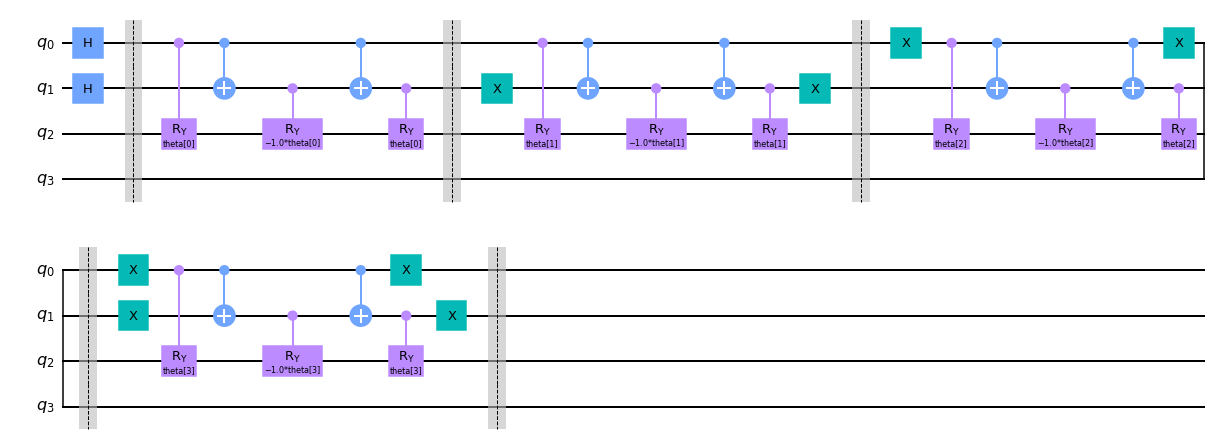

In [13]:
qc = frqi_state(feature_dim)
qc.draw('mpl')

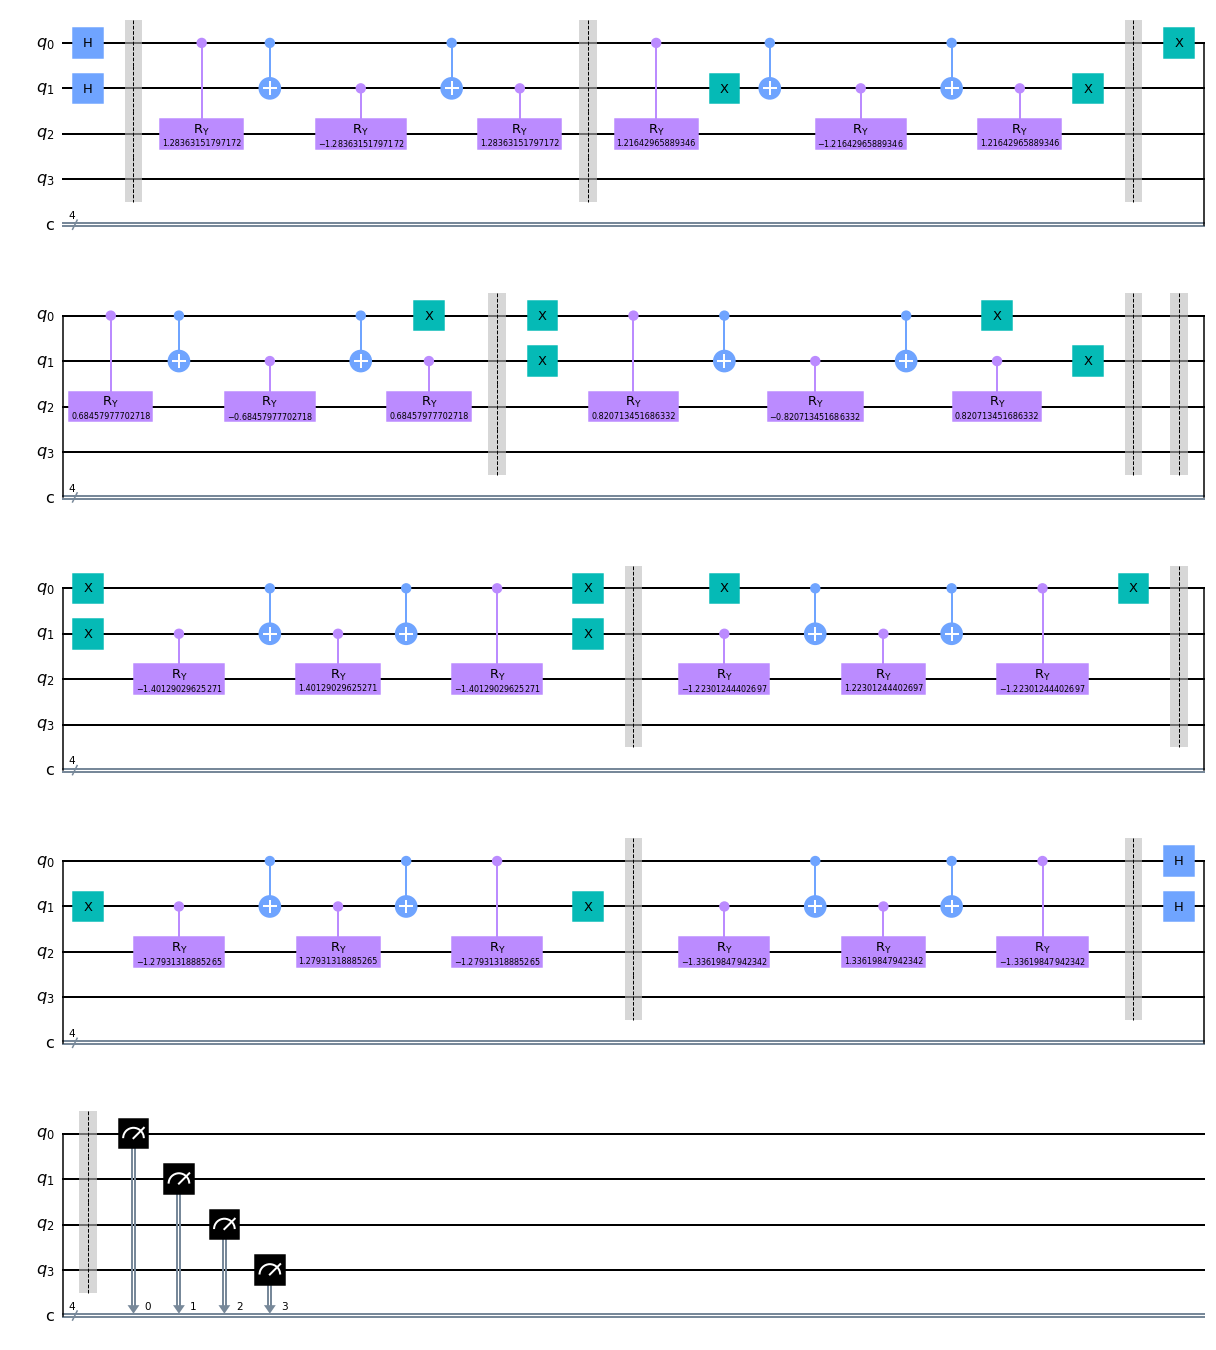

In [14]:
feature_map = frqi_state(feature_dim)
feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi_aer_qasm)

pauli_circuit = feature_kernel.construct_circuit(x_train_normed[0], x_train_normed[1])
pauli_circuit.decompose().draw('mpl')

## Classical SVC

In [15]:
model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)

#Fiting the SVM model according to the given training data.
t0 = time.time()
model.fit(x_train_normed, y_train)
print('training time', time.time()-t0)

training time 79.2976450920105


In [16]:
t0 = time.time()
accuracy = model.score(x_train_normed, y_train)
print('score(train) time', time.time()-t0)
print(f'classification accuracy on train set (size={len(y_train)}): {accuracy}')

t0 = time.time()
accuracy = model.score(x_test_normed, y_test)
print('score(test) time', time.time()-t0)
print(f'classification accuracy on test set (size={len(y_test)}): {accuracy}')
# not good, seems just random guess with accuracy 0.5

score(train) time 79.41406774520874
classification accuracy on train set (size=160): 0.9875
score(test) time 39.68394184112549
classification accuracy on test set (size=40): 0.925


## On simulator

In [19]:
from qiskit import execute, Aer

# aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
aer_qasm_sim = Aer.get_backend('aer_simulator')
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=1024, seed_simulator=None)

In [20]:
job = execute(pauli_circuit, backend = aer_qasm_sim, shots = 1024)
counts = job.result().get_counts(pauli_circuit)
counts

{'0010': 202,
 '0100': 48,
 '0110': 175,
 '0101': 45,
 '0001': 16,
 '0011': 183,
 '0111': 355}

In [22]:
print(f"Transition amplitude: {counts.get('0000',0)/sum(counts.values())}")

Transition amplitude: 0.0


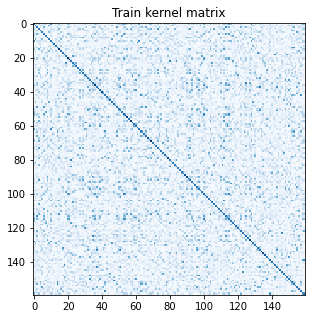

In [23]:
train_matrix= feature_kernel.evaluate(x_vec=x_train_normed)
test_matrix = feature_kernel.evaluate(x_vec=x_test, y_vec=x_train_normed)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

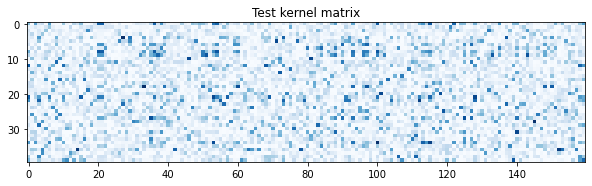

In [24]:
fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Test kernel matrix")
plt.show()